In [1]:
import os
dir = '/Users/signapoop/Desktop/autotune'
os.chdir(dir)
from autotune.core.RandomOptimiser import RandomOptimiser
from autotune.benchmarks.mnist_problem import MnistProblem
from autotune.util.best_value import best_value

In [2]:
from hyperopt import hp
import numpy as np
import matplotlib.pyplot as plt
import hyperopt.pyll.stochastic
import GPyOpt
import time

In [3]:
class TpeOptimiser(RandomOptimiser):
    def __init__(self, arms_init=[], val_loss_init=[], Y_init=[]):
        super(TpeOptimiser, self).__init__(arms_init, val_loss_init, Y_init)
        self.name = "TpeOptimiser"
    
    def run_optimization(self, problem, n_resources=None, max_iter=None, max_time=np.inf, verbosity=False):
        # problem provides generate_random_arm and eval_arm(x)
        # --- Setting up stop conditions
        if (max_iter is None) and (max_time is None):
            self.max_iter = 0
            self.max_time = np.inf
        elif (max_iter is None) and (max_time is not None):
            self.max_iter = np.inf
            self.max_time = max_time
        elif (max_iter is not None) and (max_time is None):
            self.max_iter = max_iter
            self.max_time = np.inf
        else:
            self.max_iter = max_iter
            self.max_time = max_time

        print("\n---- Running hyperband optimisation ----")
        print("Resource per iteration = {}".format(n_resources))
        print("Max iterations = {}".format(max_iter))
        print("----------------------------------------")

        # --- Initialize iterations and running time
        self.time_zero = time.time()
        self.cum_time = 0
        self.num_iterations = 0
        trials = hyperopt.Trials()
        
        # Wrap parameter space
        space = self.initialise_hyperopt_space(problem)
        
        # Wrap function
        objective_fn = lambda arm: self.initialise_hyperopt_objective(problem, n_resources, arm)
        
        # Run optimiser
        # TODO: interrupt when time budget is exceeded
        # TODO: print results intermittenly
        best = hyperopt.fmin(objective_fn, 
                             space, 
                             algo=hyperopt.tpe.suggest, 
                             max_evals=self.max_iter, 
                             max_time=self.max_time,
                             trials=trials,
                             verbose=1)
        
        # Compute statistics
        self.arms = []
        self.Y = []
        self.val_loss = []
        self.checkpoints = []
        for t in trials.trials:
            self.arms.append(t['misc']['vals'])
            self.Y.append(t['result']['test_loss'])
            self.val_loss.append(t['result']['loss'])
            self.checkpoints.append(t['result']['eval_time'] - self.time_zero)
            
        self.trials = trials
        self._compute_results()
    
    def initialise_hyperopt_objective(self, problem, n_resources, params):
        # create model file
        arms = problem.construct_arms([params])
        # run model
        val_loss, Y_new = problem.eval_arm(arms[0], n_resources)
        return {'loss': val_loss, 'status': hyperopt.STATUS_OK, 'test_loss': Y_new, 'eval_time': time.time()}
    
    def initialise_hyperopt_space(self, problem):
        def hyperopt_param_converter(hb_param):
            name = hb_param.name
            min_val = hb_param.get_min()
            max_val = hb_param.get_max()
            interval = hb_param.interval
            if hb_param.scale == "log":
                assert hb_param.logbase==np.e
                if interval:
                    return hp.qloguniform(name, min_val, max_val, interval)
                else:
                    return hp.loguniform(name, min_val, max_val)
            else:
                if interval:
                    return hp.quniform(name, min_val, max_val, interval)
                else:
                    return hp.uniform(name, min_val, max_val)
        space = {}
        for p in problem.domain.keys():
            space[p] = hyperopt_param_converter(problem.domain[p])
        return space

In [4]:
input_dir = '/Users/signapoop/Desktop/data/'
output_dir = '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/'
problem = MnistProblem(input_dir, output_dir)

==> Preparing data..
Using GPUs? : False


In [5]:
problem.domain

{'batch_size': batch_size (20.000000,2000.000000,linear),
 'learning_rate': learning_rate (-13.815511,0.000000,log),
 'momentum': momentum (0.300000,0.999000,linear),
 'weight_decay': weight_decay (-13.815511,-2.302585,log)}

In [6]:
problem.space = {
    'batch_size': hp.quniform('batch_size', 20, 2000, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(10**-6), np.log(10**0)),
    'momentum': hp.uniform('momentum', 0.3, 0.99),
    'weight_decay': hp.loguniform('weight_decay', np.log(10**-6), np.log(10**-1)),
}

In [7]:
print problem.domain['learning_rate'].get_min()

-13.815510558


In [8]:
def hyperopt_param_converter(hb_param):
    name = hb_param.name
    min_val = hb_param.get_min()
    max_val = hb_param.get_max()
    interval = hb_param.interval
    if hb_param.scale == "log":
        assert hb_param.logbase==np.e
        if interval:
            return hp.qloguniform(name, min_val, max_val, interval)
        else:
            return hp.loguniform(name, min_val, max_val)
    else:
        if interval:
            return hp.quniform(name, min_val, max_val, interval)
        else:
            return hp.uniform(name, min_val, max_val)

In [9]:
space = {}
for p in problem.domain.keys():
    space[p] = hyperopt_param_converter(problem.domain[p])

import hyperopt.pyll.stochastic

In [10]:
for i in range(10):
    print hyperopt.pyll.stochastic.sample(space)

{'learning_rate': 0.5331320708530825, 'weight_decay': 0.028873003308550405, 'batch_size': 1660.0, 'momentum': 0.8061051661594743}
{'learning_rate': 0.0004333469660501648, 'weight_decay': 0.0023744929135816016, 'batch_size': 768.0, 'momentum': 0.519133673161086}
{'learning_rate': 1.3108832522690404e-05, 'weight_decay': 4.185065949760396e-05, 'batch_size': 571.0, 'momentum': 0.31160895772755426}
{'learning_rate': 0.000897410422202285, 'weight_decay': 1.0639877805290184e-05, 'batch_size': 38.0, 'momentum': 0.8911648409370543}
{'learning_rate': 0.016427845751772398, 'weight_decay': 2.6317775714291143e-05, 'batch_size': 138.0, 'momentum': 0.6578664230618079}
{'learning_rate': 1.2698283603877009e-05, 'weight_decay': 0.0022899742358505654, 'batch_size': 1583.0, 'momentum': 0.7783177915668202}
{'learning_rate': 0.0022692833384448385, 'weight_decay': 0.0005196245399078936, 'batch_size': 707.0, 'momentum': 0.37509900824448617}
{'learning_rate': 7.117260393843797e-05, 'weight_decay': 0.0039385075

In [16]:
tpe_opt = TpeOptimiser()
tpe_opt.run_optimization(problem, n_resources=1, max_time=100)


---- Running hyperband optimisation ----
Resource per iteration = 1
Max iterations = None
----------------------------------------
0

Loading arm with parameters.....
{'learning_rate': 0.003205973601636503, 'batch_size': 156.0, 'filename': '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/arm236/model.pth', 'n_resources': 1, 'momentum': 0.9741787286475616, 'weight_decay': 0.0013127978009259687, 'dir': '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/arm236'}

Epoch: 0
 [=================================================================>]  Step: 212ms | Tot: 36s380ms | Loss: 0.477 | Acc: 86.875% (10425/1200 120/120  
 [=================================================================>]  Step: 866ms | Tot: 37s246ms | Loss: 0.446 | Acc: 87.800% (8780/1000 100/100 
num iteration: 1, time elapsed: 3.02s, f_current: 0.13125, f_best: 0.13125

Loading arm with parameters.....
{'learning_rate': 1.6024737111015886e-05, 'batch_size': 1587.0, 'filename': '/Users/

num iteration: 11, time elapsed: 42.77s, f_current: 0.30675, f_best: 0.12075

Loading arm with parameters.....
{'learning_rate': 3.0184053431159732e-05, 'batch_size': 863.0, 'filename': '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/arm247/model.pth', 'n_resources': 1, 'momentum': 0.6992120880407375, 'weight_decay': 8.877092755948612e-05, 'dir': '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/arm247'}

Epoch: 0
 [=================================================================>]  Step: 180ms | Tot: 1m19s | Loss: 2.389 | Acc: 12.625% (1515/1200 120/120  
 [=================================================================>]  Step: 1s557ms | Tot: 1m21s | Loss: 2.382 | Acc: 13.060% (1306/1000 100/100 
num iteration: 12, time elapsed: 47.06s, f_current: 0.87375, f_best: 0.12075

Loading arm with parameters.....
{'learning_rate': 1.7808364596463615e-05, 'batch_size': 109.0, 'filename': '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/

 [=================================================================>]  Step: 207ms | Tot: 2m9s | Loss: 0.501 | Acc: 88.125% (10575/1200 120/120 
 [=================================================================>]  Step: 797ms | Tot: 2m10s | Loss: 0.456 | Acc: 89.340% (8934/1000 100/100 
num iteration: 23, time elapsed: 96.44s, f_current: 0.11875, f_best: 0.11592

Loading arm with parameters.....
{'learning_rate': 0.9891501457353824, 'batch_size': 438.0, 'filename': '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/arm259/model.pth', 'n_resources': 1, 'momentum': 0.864231326429357, 'weight_decay': 1.3522721300093814e-06, 'dir': '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/arm259'}

Epoch: 0
 [=================================================================>]  Step: 265ms | Tot: 2m13s | Loss: 6.621 | Acc: 84.442% (10133/1200 120/120 
 [=================================================================>]  Step: 927ms | Tot: 2m14s | Loss: 5.878 | Ac

In [17]:
len(tpe_opt.checkpoints)

25

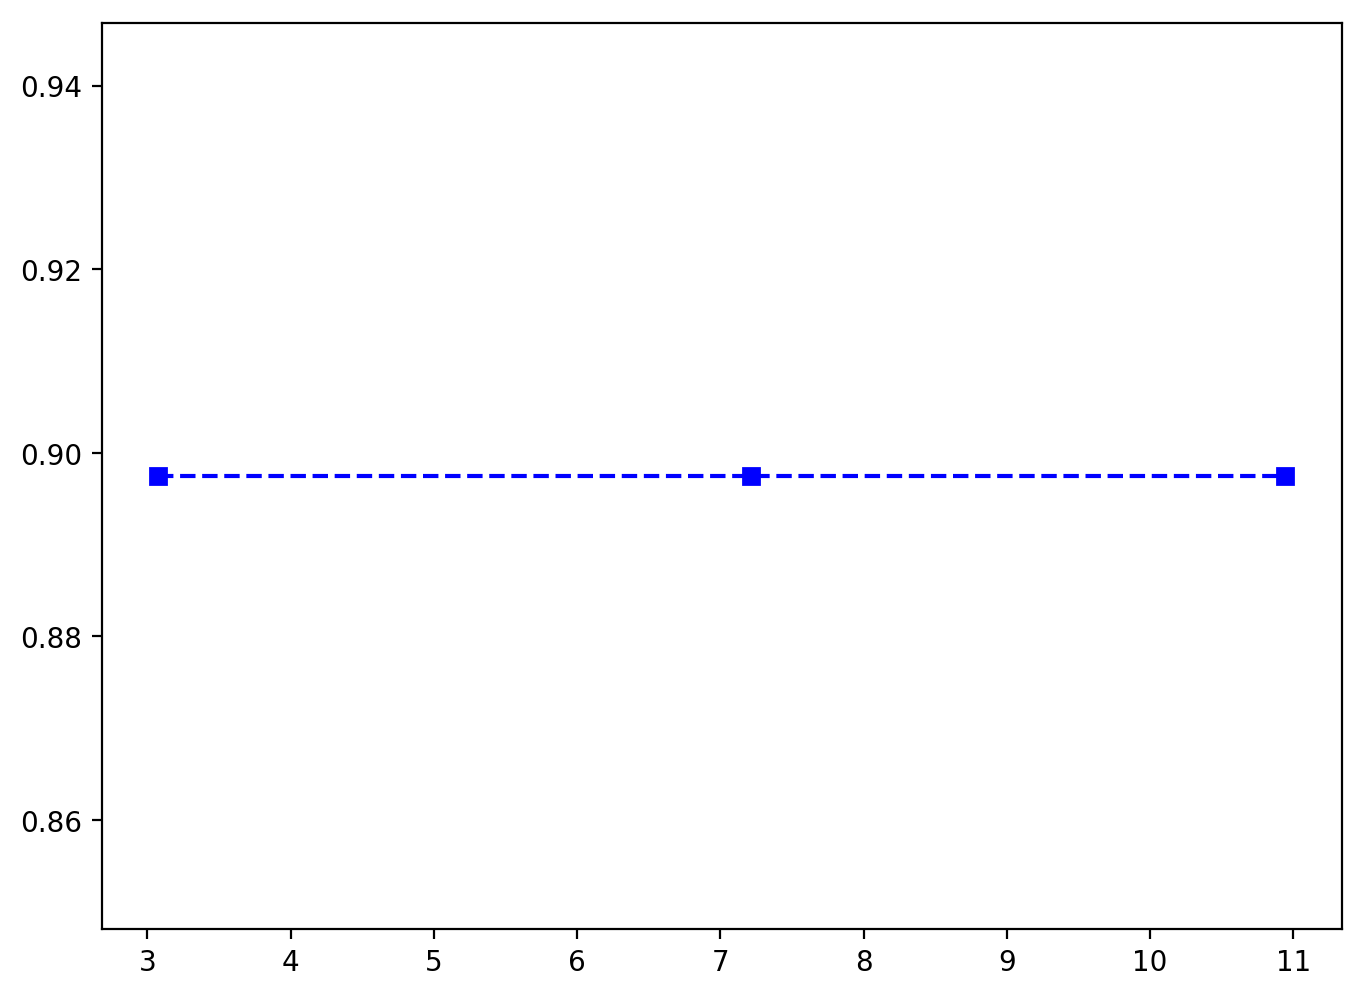

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)
ax.plot(tpe_opt.checkpoints, tpe_opt.Y_best, '--bs', label=tpe_opt.name)

In [14]:
a= 4-2>3

In [15]:
a

False